# Machine Learning: Classification

#### Student Intervention System

- The objective of this workbook is to walk through the process of selecting and developing a model that will predict the likelihood that a given student will pass, thus helping diagnose whether or not an intervention is necessary. The model is developed based on a subset of data that consists of information from randomly sample students, and it will be tested against a subset of the data that is kept hidden from the learning algorithm, in order to test the model’s effectiveness on data outside the training set.

In [122]:
#Python Version --> Python 3.5
import sys
print(sys.version)

3.5.2 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


### Import libraries

In [15]:
import numpy as np
import pandas as pd
import csv
import time

#Scikit-Learn Machine Learning 
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split

import pylab as pl
import matplotlib.pyplot as pl
from sklearn.preprocessing import scale
from sklearn import metrics

#Seaborn 
pl.style.use('fivethirtyeight')
import seaborn as sns

In [16]:
#Read in csv file into pandas dataframe
student_data = pd.read_csv("student-data.csv")
print ("Student data read successfully!")

Student data read successfully!


In [18]:
#return the first 5 rows (all columns)
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


### Exploratory Analysis

In [26]:
#Dimensions of Data 
n_students = student_data.shape[0] #number of students (rows)
n_features = student_data.shape[1]-1 #number of features (columns)
print("Total Number of Students: {}".format(n_students))
print("Total Number of Features: {}".format(n_features))

Total Number of Students: 395
Total Number of Features: 30


In [27]:
n_passed =  student_data[student_data['passed'] =='yes'].shape[0]
n_failed =  student_data[student_data['passed'] == 'no'].shape[0]
grad_rate = (n_passed*1.0) / (n_students*1.0) * 100

print("Number of students who passed: {}".format(n_passed))
print("Number of students who failed: {}".format(n_failed))
print("Number of features: {}".format(n_features))
print("Graduation rate of the class: {:.2f}%".format(float(grad_rate)))

Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


In [37]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print("Feature column(s):{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
#print X_all.head()  # print the first 5 rows

Feature column(s):['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed


In [59]:
# Preprocess feature columns
def preprocess_features(X):
    df_preprocess = pd.DataFrame(index=X.index) # output dataframe, initially empty
    # iterate through each column
    for colname, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object: #if data type == object (i.e. non-numeric)
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # If data is non-numeric and consist of more than 2 level
        # convert todummy variables (indicator variables)
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=colname)  
        #join columns to one dataframe
        df_preprocess = df_preprocess.join(col_data)  # collect column(s) in output dataframe
    return df_preprocess

X_all = preprocess_features(X_all)
print("Processed Feature Columns")
X_all.head()

Processed Feature Columns


,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1.0,0.0,1.0,0.0,18,0.0,1.0,1.0,0.0,1.0,...,1,0,0,4,3,4,1,1,3,6
1,1.0,0.0,1.0,0.0,17,0.0,1.0,1.0,0.0,0.0,...,1,1,0,5,3,3,1,1,3,4
2,1.0,0.0,1.0,0.0,15,0.0,1.0,0.0,1.0,0.0,...,1,1,0,4,3,2,2,3,3,10
3,1.0,0.0,1.0,0.0,15,0.0,1.0,1.0,0.0,0.0,...,1,1,1,3,2,2,1,1,5,2
4,1.0,0.0,1.0,0.0,16,0.0,1.0,1.0,0.0,0.0,...,1,0,0,4,3,2,1,2,5,4


In [63]:
#Format Target yes/no values with 1/0
y = pd.DataFrame(y_all, index = y_all.index)
y = y.replace(['yes', 'no'], [1, 0])
#in the form (X, 1), but the method expects a 1d array and has to be in the form (X, )

#join dataset
df_data = pd.concat([X_all, y], axis = 1)
df_data.head() #passed --> response variable

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,1.0,0.0,1.0,0.0,18,0.0,1.0,1.0,0.0,1.0,...,0,0,4,3,4,1,1,3,6,0
1,1.0,0.0,1.0,0.0,17,0.0,1.0,1.0,0.0,0.0,...,1,0,5,3,3,1,1,3,4,0
2,1.0,0.0,1.0,0.0,15,0.0,1.0,0.0,1.0,0.0,...,1,0,4,3,2,2,3,3,10,1
3,1.0,0.0,1.0,0.0,15,0.0,1.0,1.0,0.0,0.0,...,1,1,3,2,2,1,1,5,2,1
4,1.0,0.0,1.0,0.0,16,0.0,1.0,1.0,0.0,0.0,...,0,0,4,3,2,1,2,5,4,1


In [87]:
df_data.describe()
#statistics from df1 dataframe

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,0.883544,0.116456,0.526582,0.473418,16.696203,0.222785,0.777215,0.711392,0.288608,0.103797,...,0.832911,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,0.670886
std,0.321177,0.321177,0.499926,0.499926,1.276043,0.416643,0.416643,0.453690,0.453690,0.305384,...,0.373528,0.472300,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,0.470487
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,17.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,18.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,1.000000


In [90]:
#Data Correlation:
df = df_data.corr()
corr_target = df.ix[-1][:-1] #Target is last column in the DataFrame
predict = corr_target.sort_values(ascending=False)
df_sort = corr_target.sort_values(ascending=False)
print(df_sort)

higher               0.157708
Medu                 0.115396
Fedu                 0.108057
paid                 0.092665
Mjob_health          0.080484
studytime            0.074613
sex_M                0.070618
reason_reputation    0.067771
internet             0.061791
Mjob_services        0.060114
guardian_father      0.059347
reason_other         0.053316
Fjob_teacher         0.052557
address_U            0.052282
famrel               0.046683
Pstatus_A            0.044050
famsize_LE3          0.041842
school_GP            0.031254
Fjob_other           0.026180
activities           0.012414
guardian_mother      0.009890
Mjob_teacher         0.001349
reason_home         -0.001526
Fjob_health         -0.001962
nursery             -0.008784
freetime            -0.018321
Walc                -0.029957
school_MS           -0.031254
Fjob_at_home        -0.034839
Mjob_at_home        -0.039031
Fjob_services       -0.041572
famsize_GT3         -0.041842
Pstatus_T           -0.044050
traveltime

### Split Data Into Training/Testing Sets

In [118]:
def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 1, test_size=num_test, random_state = None)
    for train, test in sss:
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    return X_train, X_test, y_train, y_test

# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = round(num_all*0.75)  # about 75% of the data
num_test = num_all - num_train
#print(num_test)

y = student_data['passed'] # identify target variable
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)

print("Training Set: {0:.2f} Samples".format(X_train.shape[0]))
print("Testing Set: {0:.2f} Samples".format(X_test.shape[0]))

Training Set: 296.00 Samples
Testing Set: 99.00 Samples


### Train Model

In [163]:
def train_classifier(clf, X_train, y_train):
    start = time.time() #specifty start time
    
    clf.fit(X_train, y_train) #train model
    
    end = time.time() #specify end time
    train_clf_time = end - start #total training time
    print("Total Training Time (secs): {:.3f}".format(train_clf_time))
    return train_clf_time 

### Make Prediction on Training Set & Compute F1 Score

In [164]:
def predict_labels(clf, features, target):
    start = time.time() #start prediction time
    y_pred = clf.predict(features) #predict on testing set
    end = time.time() # stop prediction time
    prediction_time = end - start # total prediction time
    print("Prediction Time (secs): {:.3f}".format(prediction_time))
    
    p,r,f,s = precision_recall_fscore_support(target.values,
              y_pred, average='binary', pos_label='yes')
    print("Precision Score: {0:.4f}".format(p))
    print("Recall Score: {0:.4f}".format(r))
    print("F1 Score: {0:.4f}".format(f))

### Train and Predict



Model: GaussianNB


**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.002
Prediction Time (secs): 0.000
Precision Score: 0.7816
Recall Score: 0.8090
F1 Score: 0.7951
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.000
Precision Score: 0.7541
Recall Score: 0.6970
F1 Score: 0.7244


Model: SVC


**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.006
Prediction Time (secs): 0.005
Precision Score: 0.7704
Recall Score: 0.9950
F1 Score: 0.8684
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.002
Precision Score: 0.7317
Recall Score: 0.9091
F1 Score: 0.8108


Model: RandomForestClassifier


**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.111
Prediction Time (secs): 0.00

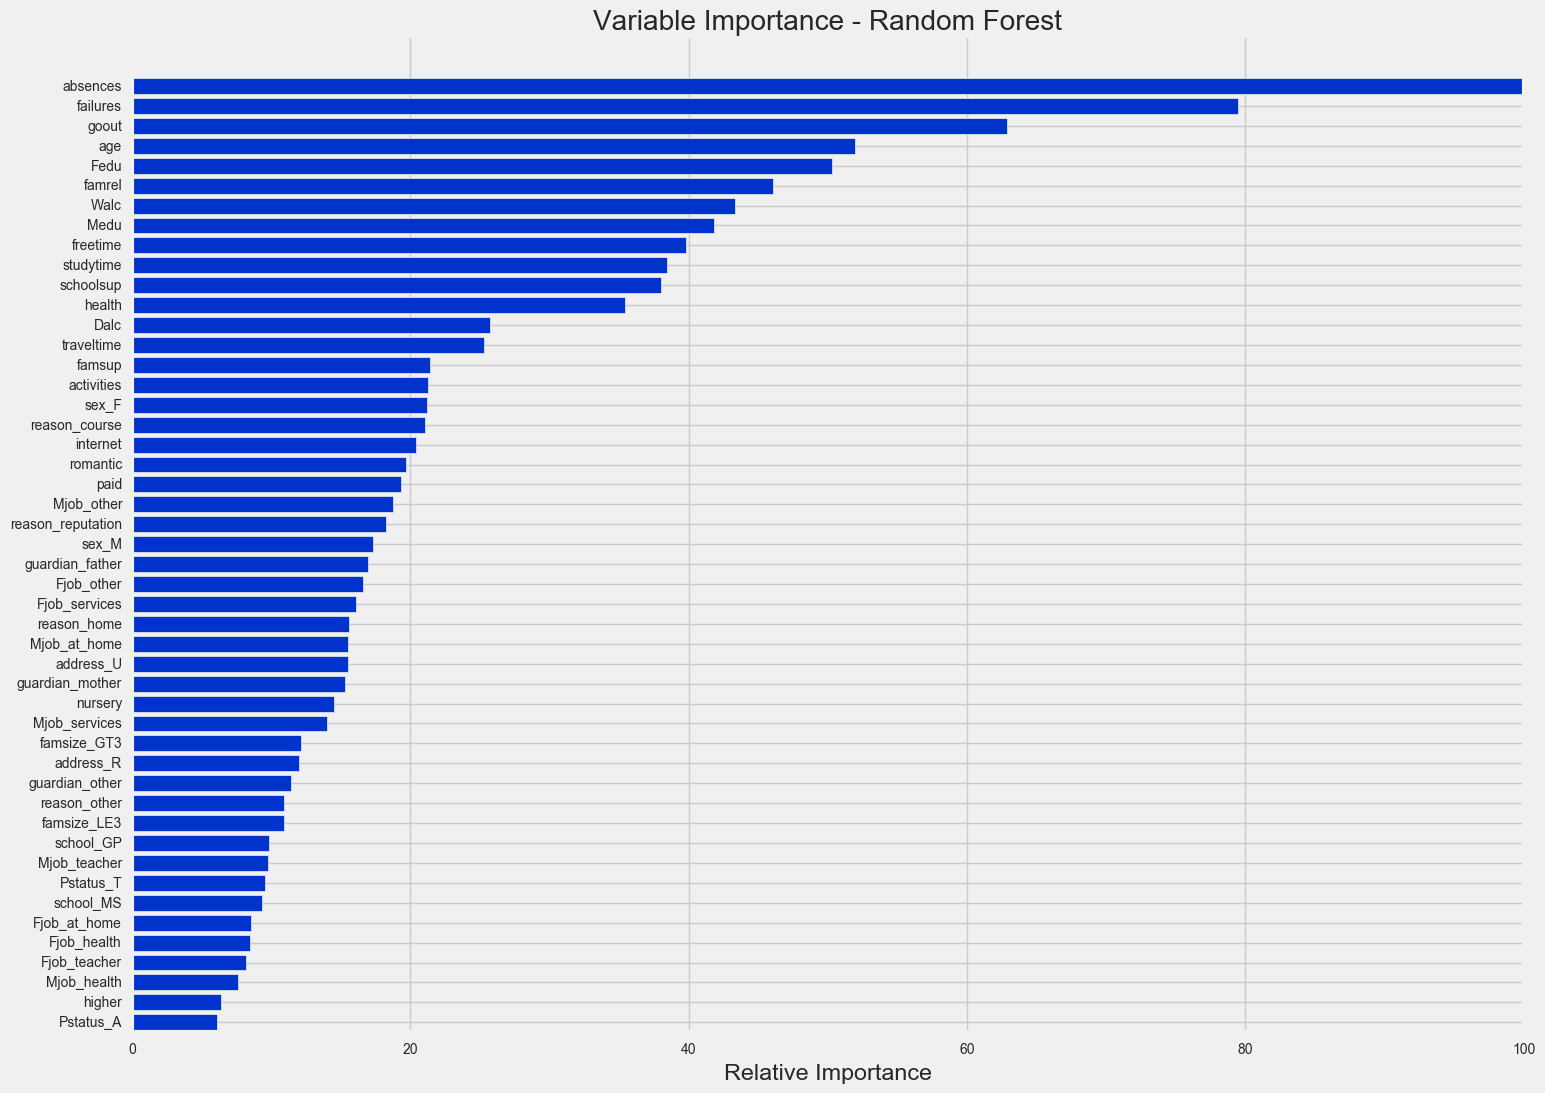

In [181]:
clf_NB = GaussianNB()
clf_SVC = SVC()
clf_RF = RandomForestClassifier(n_estimators = 100)

algorithms = [clf_NB,clf_SVC,clf_RF]

for model in algorithms:
    print("\n")
    print("==============================")
    print("Model: {}".format(model.__class__.__name__))
    print("==============================")
    print("\n")
    print("**********************************************************")
    print("**Training**")
    print("Data Size:",len(X_train))
    # Fit model to training data
    train_classifier(model, X_train, y_train)

    # Predict on training set and compute F1 score
    predict_labels(model, X_train, y_train)

    #Predict on Testing Data
    print("**********************************************************")
    print("**Testing**")
    print("Data Size:",len(X_test))
    predict_labels(model, X_test, y_test)
    
    if model == clf_RF:
        print("\n")
        feature_importance(clf_RF)

In [183]:
#Feature Selection --> Random Forest
def feature_importance(clf):
    # Relative Importance (Features)
    clf.fit(X_train,y_train)
    # Get Feature Importance from the classifier
    feature_importance = clf.feature_importances_
    # Normalize The Features
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    # Sort Features and Creat Horizontal Bar Plot
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    pl.figure(figsize=(16, 12))
    pl.barh(pos, feature_importance[sorted_idx], align='center', color='#0033CC')
    pl.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
    pl.xlabel("Relative Importance")
    pl.title("Variable Importance - Random Forest")
    pl.show()

### Run All Models ( 10 iterations) 

In [128]:
# training and predicting on various testing/training sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print("*******************************************")
    print("Training Set Size: {}".format(len(X_train)))
    train_diff = train_classifier(clf, X_train, y_train)
    
    # Train and predict on diff. training set sizes
    # Pass X_train and y_train to predict_labels function
    f1_score_train, pred_time_train = predict_labels(clf, X_train, y_train)
    print("F1 score for training set:",(f1_score_train))
    
    # Predict on test data
    f1_score_test, pred_time_test = predict_labels(clf, X_test, y_test)
    print("F1 score for test set:",(f1_score_test))
    
    return (f1_score_train, f1_score_test, train_diff, pred_time_test)

In [129]:
# run all models 
def run_all_models(classifiers):
    for clf in classifiers:
        df = pd.DataFrame(columns = [
                    'Training_Size',
                    'Testing_Size',
                    'Training_Time',
                    'Prediction_Time',
                    'F1_Training_Score',
                    'F1_Testing_Score'])

        y = student_data['passed']
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
        
        num_times_to_run = 10
        sizes = [100,200,300]
        for size in sizes: 
            for x in range(0, num_times_to_run): 
                f1_score_train, f1_score_test, train_time, pred_time_test = train_predict(clf, X_train[:size], y_train[:size], X_test, y_test)
                        
                df = df.append({
                        'Training_Size': len(X_train[:size]),
                        'Testing_Size': X_test.shape[0],
                        'Training_Time': train_time,
                        'Prediction_Time': pred_time_test,
                        'F1_Training_Score': f1_score_train,
                        'F1_Testing_Score': f1_score_test}, 
                        ignore_index= True)
            
            df = df[(df.Training_Size == size)]
            df_mean = df.mean()
        
            print("**********************************************************")
            print("Mean Statistics:")
            print(df_mean)
            print("**********************************************************")

# Fine Tune Model:

In [20]:
# Fine-tune the model and report the best F1 score

# Reformat "Y" from 'yes/no' to '1/0'
def reformat(col_data):
    return col_data.replace(['yes', 'no'], [1, 0])

def iterate_fit_predict(number_runs):
        f1_scores = []
        gamma = []
        C = []

        y = reformat(student_data['passed'])
        
        for num in range(0,number_runs):
            X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
            clf_SVC = SVC()
            parameters = [{'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}]
    
            
            clf = GridSearchCV(clf_SVC, parameters, scoring = 'f1')
            
            # Fit the learner to the training data to obtain the best parameter set
            clf.fit(X_train, y_train)
            f1_scores.append(clf.score(X_test, y_test))
            gamma.append(clf.best_params_['gamma'])
            C.append(clf.best_params_['C'])
            clf = clf.best_estimator_
            #print clf
        
        df_f1 = pd.Series(f1_scores)
        df_gamma = pd.Series(gamma)
        df_C = pd.Series(C)
        
        print clf
        print "\nF1 Scores:"
        print df_f1
        print "\nC:"
        print df_C
        print "\nGamma:"
        print df_gamma

        print "\nAverage F1 Test Scores:"
        print df_f1.mean()
        print "\nAverage C:"
        print df_C.mean()
        print "\nAverage Gamma:"
        print df_gamma.mean()
        

In [21]:
iterate_fit_predict(3)

/Library/Python/2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

F1 Scores:
0    0.807947
1    0.810127
2    0.800000
dtype: float64

C:
0    100
1      1
2     10
dtype: int64

Gamma:
0    0.0001
1    0.1000
2    0.0010
dtype: float64

Average F1 Test Scores:
0.806024534049

Average C:
37.0

Average Gamma:
0.0337


# Confusion Matrix

In [33]:
from pandas_confusion import ConfusionMatrix

def iterate_fit_predict_score(number_runs):
        f1_scores = []
        
        y = reformat(student_data['passed'])
        
        for num in range(0,number_runs):
            X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
            clf_SVC = SVC()
            parameters = [{'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}]
    
            clf = GridSearchCV(clf_SVC, parameters, scoring = 'f1')
            clf.fit(X_train, y_train)
            y_true, y_pred = y_test, clf.predict(X_test)
            target_names = ["failed","passed"]
            print(classification_report(y_true, y_pred,target_names=target_names))    
            
            # Print Conf_Matrix
            conf_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
            print "\nConf_Matrix:", conf_matrix
            
            #Normalize Conf_Matrix:
            conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
            print "\nNormalize Conf_Matrix:", conf_matrix_norm
            
            #Generate Confusion Matrix Plot
            conf_matrix = metrics.confusion_matrix(y_true, y_pred)
            labels = ['fail','pass']
            pl.title('SVC: Confusion Matrix')
            ax = pl.axes
            sns.heatmap(conf_matrix, 
                    xticklabels=labels, 
                    yticklabels=labels,
                    annot=True, fmt='')
            pl.xlabel("Predicted")
            pl.ylabel("True")

             precision    recall  f1-score   support

     failed       0.67      0.26      0.37        31
     passed       0.72      0.94      0.82        64

avg / total       0.70      0.72      0.67        95


Conf_Matrix: Predicted   0   1  All
Actual                
0           8  23   31
1           4  60   64
All        12  83   95

Normalize Conf_Matrix: Predicted         0         1       All
Actual                                 
0          0.129032  0.179688  0.163158
1          0.064516  0.468750  0.336842
All        0.193548  0.648438  0.500000


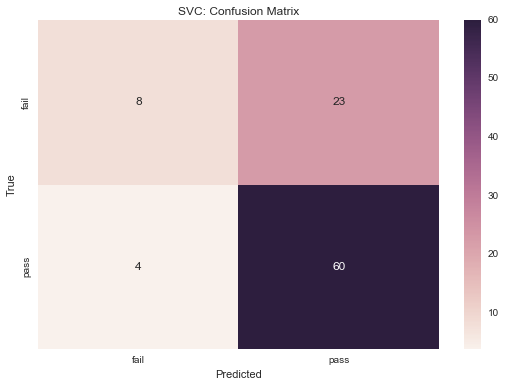

In [34]:
iterate_fit_predict_score(1)

# ROC and AUC

In [205]:
# Support Vector Machines:

def reformat(col_data):
    return col_data.replace(['yes', 'no'], [1, 0])

def iterate_fit_predict_svc(number_runs):
        f1_scores = []
        auc = []

        y = reformat(student_data['passed'])
        
        for num in range(0,number_runs):
            X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)
            clf_SVC = SVC(probability=True)
            parameters = [{'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}]
            
            clf = GridSearchCV(clf_SVC, parameters, scoring = 'f1')
            
            # Fit the learner to the training data to obtain the best parameter set
            clf.fit(X_train, y_train)
            f1_scores.append(clf.score(X_test, y_test))
            clf = clf.best_estimator_
            
            # Generate ROC Curve
            preds = clf.predict_proba(X_test)[:,1]
            fpr, tpr, _ = metrics.roc_curve(y_test, preds)
            df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
            auc_1 = metrics.auc(fpr,tpr)
            auc.append(metrics.auc(fpr,tpr))
            df_auc = pd.DataFrame(auc)
            g1 = ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) +\
            geom_area(alpha=0.1, size=5, colour='green', fill = 'green') +\
            geom_line(aes(y='tpr')) +\
            ggtitle("ROC: Area Under Cuve = %s" % str(auc_1)) 
            print g1
        print "\nAverage Area Under Curve"
        print df_auc.mean()


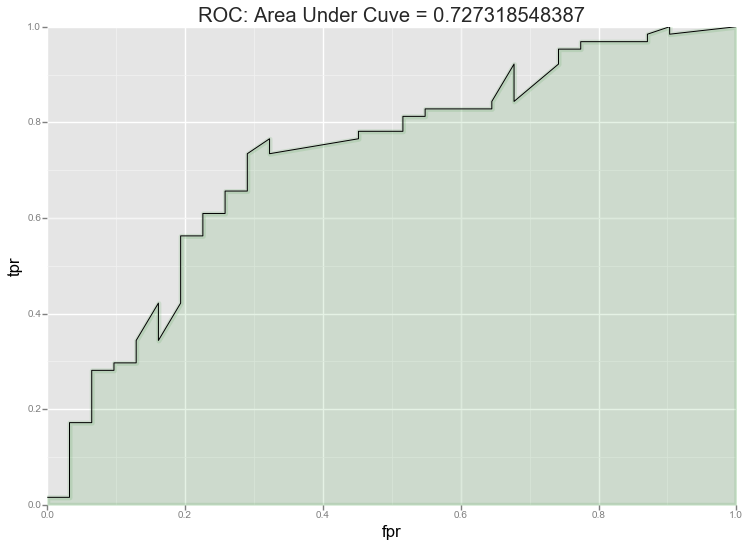

<ggplot: (279092817)>

Average Area Under Curve
0    0.727319
dtype: float64


In [209]:
iterate_fit_predict_svc(1)